### 統計學習與深度學習
### Homework 2
R08725033 資管碩二 陳柏勳

### 第一題 [Data Preprocessing]
本題依序進行以下操作（處理）：
* 使用Pandas讀入UCI dataset的train和test資料集
* 處理NAN，還有文件中提及的"?"等缺漏值
* 轉換50k to 0 and 1
* 將test和train暫時合併，以進行一致的標準化。針對num_col透過sklearn的StandardScaler進行標準化；對cat_col使用pandas的get_dummies進行1-of-k的encoding，並丟棄整列中出現少於10個觀察值的列。
* 和adult50kp['columnname']進行對齊，並將label列指定成y值
* 藉由train.index的長度還原回train/ test
* 最後轉換成numpy的資料型態

In [1]:
# https://machinelearningmastery.com/load-machine-learning-data-python/
import pandas as pd
from sklearn import preprocessing
import pickle
import numpy as np

names = ['age', 'workclass', 'fnlwgt', 'education', 'educational-num', 'marital-status', 'occupation', 'relationship'
         , 'race', 'gender', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'label']
train = pd.read_csv('adult.data', names=names, sep=', ', engine='python')
test = pd.read_csv('adult.test', names=names, sep=', ', engine='python')

# pd.isna(train).any()
train.dropna()
# pd.isna(test).any()
test.dropna()

# Convert Unknown to "?", so remove it.
# https://stackoverflow.com/questions/36620175/futurewarning-elementwise-comparison-failed-returning-scalar-instead
train = train[(train.astype(str) != '?').all(axis=1)] # All feature isn't ? in the row, reduce columns
test = test[(test.astype(str) != '?').all(axis=1)]

# len(train): 32561 to 30162

# Transfer label to 1 and 0
# https://blog.csdn.net/xueruixuan/article/details/80237481
train.loc[:,'label'] = train.loc[:,'label'].map({'>50K':1, '<=50K':0})
test.loc[:,'label'] = test.loc[:,'label'].map({'>50K.':1, '<=50K.':0})

num_col = ['age', 'fnlwgt', 'educational-num', 'capital-gain', 'capital-loss', 'hours-per-week']
cat_col = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'native-country']

# Use all data to normalize, make sure the meaning is same
all_data = pd.concat([train, test], axis=0)

# Normalize num data
xscaler = preprocessing.StandardScaler().fit(all_data.loc[:,num_col])
all_data.loc[:,num_col] = xscaler.transform(all_data.loc[:,num_col])

# https://medium.com/@PatHuang/%E5%88%9D%E5%AD%B8python%E6%89%8B%E8%A8%98-3-%E8%B3%87%E6%96%99%E5%89%8D%E8%99%95%E7%90%86-label-encoding-one-hot-encoding-85c983d63f87
all_data = pd.get_dummies(all_data, columns = cat_col)

# https://www.delftstack.com/zh-tw/howto/python-pandas/how-to-get-the-sum-of-pandas-column/
for c in all_data.columns:
    if all_data[c].sum()>=1 and all_data[c].sum()<10:
        all_data = all_data.drop(c,axis=1)
        
'''
Align with the order in adult_m50k.pickle
'''
dsfile = 'adult_m50k.pickle'
with open(dsfile, 'rb') as fh1:
    adult50kp = pickle.load(fh1)
    
# Align it
all_data_sort = all_data.loc[:,adult50kp['columnname']]

# Split to x and y
all_y = all_data.loc[:,'label']

# Split to train and test
x_train = all_data_sort.iloc[:len(train.index),:]
x_test = all_data_sort.iloc[len(train.index):,:]
y_train = all_y[:len(train.index)]
y_test = all_y[len(train.index):]

# To numpy
x_train = x_train.to_numpy()
x_test = x_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [2]:
elems = ['x_train', 'x_test', 'y_train', 'y_test']

for aelem in elems:
    cnomatch = np.sum(adult50kp[aelem] != adult50kp[aelem])
    if cnomatch == 0:
        print(aelem, "match!")
    else:
        print(aelem, "%d elements no match!" % cnomatch)

x_train match!
x_test match!
y_train match!
y_test match!


前處理完後的結果，和題目提供的"adult_m50k.pickle"吻合。

### 第二題 [ROC and AUC]

In [1]:
import pickle
from sklearn.linear_model import LogisticRegression
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')

%matplotlib inline

# load dataset
dsfile = 'adult_m50k.pickle'
with open(dsfile, 'rb') as fh1:
    adult50kp = pickle.load(fh1)
    
#train prediction model    
c = 0.3
lr2 = LogisticRegression(solver = 'lbfgs', C= c, max_iter = 1000)
lr2.fit(adult50kp['x_train'], adult50kp['y_train'])
#make prediction
ypred = lr2.predict(adult50kp['x_test'])
ypredprob = lr2.predict_proba(adult50kp['x_test'])
#compute accuracy
ncorrect = np.sum(adult50kp['y_test'] == ypred)
accuracy_sk = ncorrect / adult50kp['y_test'].shape[0]
print("Accuracy = %f" % accuracy_sk)   

Accuracy = 0.848340


* Q2.1 (17.5%): 基於`adult50kp['y_test']`與`ypredprob`繪製ROC Curve。

本題依序進行以下操作（處理）：
* 以0.01為間距，計算threshold自p=0~1（每次提高0.01）的TPR和FPR
* 再和亂猜的45度角線進行比較

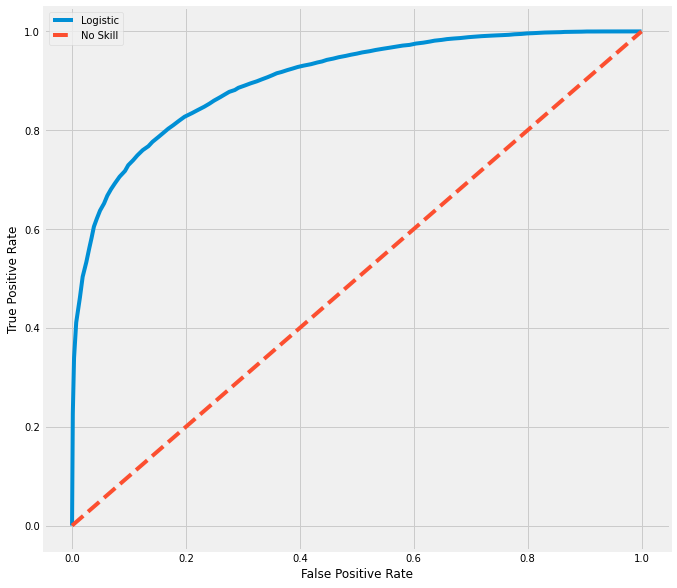

In [30]:
# p = 0, TP = TP + FN, FP = FP + TN (All positive)
TPR = [1]
FPR = [1]

for p in range(0, 100):
    
    TP = 0
    FP = 0
    FN = 0
    TN = 0
    
    for i in range(len(ypredprob)):
        if ypredprob[i][0] > p/100 and adult50kp['y_test'][i]==0:
            TP += 1
        elif ypredprob[i][0] > p/100 and adult50kp['y_test'][i]==1:
            FP += 1
        elif ypredprob[i][0] < p/100 and adult50kp['y_test'][i]==0:
            FN += 1
        else:
            TN += 1
    
    TPR.append(TP/(TP+FN))
    FPR.append(FP/(FP+TN))

# p = 1, TP = 0, FP = 0 (All negative)
TPR.append(0)
FPR.append(0)

# https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/
plt.figure(figsize=(10, 10))
plt.plot(FPR, TPR, label='Logistic')
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

由ROC Curve可知，本題給定的模型"Reasonable separation between the classes, mostly convex." Ex. 在TPR = 0.8時，FPR處在約莫0.18的不錯表現。

* Q2.2 (17.5%): 計算繪製出的ROC Curve的AUC。

依照題目給定的梯形公式，使用上一題的資料點（TPR, FPR），以0.01為尺度由p=1計算至p=0，求出近似的AUC。

In [43]:
AUC = 0

# Right top to left bottom, Make sure FPR and TPR[i-1] > [i]
for i in range(1, len(TPR)-1):
    height = (TPR[i]+TPR[i-1])/2
    width = FPR[i-1]-FPR[i]
    area = height*width
    AUC += area

print("AUC = ", AUC)

AUC =  0.903160913113818


模型的AUC約為0.903，擁有不錯的表現。

### 第三題 [Logistic Regression with L2 Regularization]

* Q1.1 (15%) Derive the gradient and hessian matrix for the new E(w). 

Origin $E(w) = \frac{\lambda}{2} w^T w - \sum_{i=1}^n [ t_i \ln y_i  + (1 - t_i) \ln (1 - y_i)],$  

New $E(w) = \frac{1}{2} w^T \Lambda w - \sum_{i=1}^n [ t_i \ln y_i  + (1 - t_i) \ln (1 - y_i)],$  
where $y_i = \frac{1}{1 + exp({-w^T x_i})}$.

#### Gradient Matrix
針對新的 $E(w)$ 求 $\frac{dE(w)}{dw}$  

由於新舊兩式不同的地方為 $\lambda$ to $\Lambda$，因此代換原本的Gradient Matrix公式：

$\frac{dE(w)}{dw} = \sum_{i=1}^n (y_i- t_i)x_i + \lambda w$ to  

$\frac{dE(w)}{dw} = \sum_{i=1}^n (y_i- t_i)x_i + \Lambda w$,  
where $y_i = \frac{1}{1 + exp({-w^T x_i})}$.

#### Hessian Matrix
Hessian為 $E(w)$ 的二階導數，因此便是對Gradient在進行一次偏微分：  

$\frac{dGradient}{dw} = \sum_{i=1}^n y_n(1 - y_n)x_i x_i^T + \Lambda I$,  
where $y_i = \frac{1}{1 + exp({-w^T x_i})}$.

* Q1.2 (25%) Create your mylogistic_l2 class. Train your model and show the learned $w$ as well as test accuracy for the cases below. If $w$ is too long for you, show selected $w$ for continuous-valued, binary-valued, and the constant term.  
  * 依照公式計算Error, Gradient和Hessian，並持續更新w直至進步幅度小於10^-5
  * add_intercept決定是否加intercept項

In [4]:
import numpy as np

class mylogistic_l2():
    def __init__(self, reg_vec, max_iter = 100, tol = 1e-5, add_intercept = True):
        """reg_vec: the regularization coefficient vector
           max_iter: maximum number of iteration to run for the Newton method
           tol: tolerance for the objective function
           add_intercept: whether to add intercept (a column of ones) at last column of the feature matrix"""
        ### Add your code here
        self.reg_vec = reg_vec
        self.max_iter = max_iter
        self.tol = tol
        self.add_intercept = add_intercept
        
    def error(self, w, x, t, lambda_vec):
        # error function
        error_f = np.dot(np.dot(w.T, np.diag(lambda_vec)), w)
        for i in range(x.shape[0]):
            y_i = 1/(1+np.exp(-1*np.dot(w.T,x[i,:])))
            error_f -= (np.dot(t[i], np.log(y_i)) + np.dot(1-t[i], np.log(1-y_i)))
        
        return error_f
        
    def gradient(self, w, x, t, lambda_vec):
        # Compute y
        y = []
        for i in range(x.shape[0]):
            y_i = 1/(1+np.exp(-1*np.dot(w.T,x[i,:])))
            y.append(y_i)
        
        # Compute gradient matrix, lambda_mat is a diagonal matrix (1d to 2d)
        gradient_mat = np.dot(np.diag(lambda_vec), w) + np.dot(x.T, np.array(y)-t)
        return gradient_mat
        
    def hessian(self, w, x, t, lambda_vec):
        # Compute y
        y = []
        for i in range(x.shape[0]):
            y_i = 1/(1+np.exp(-1*np.dot(w.T,x[i,:])))
            y.append(y_i)
        
        # Compute Hessian matrix
        R = np.diag(np.array(y)*(1-np.array(y))) # 1D to 2D
        hessian_mat = np.dot(np.dot(x.T, R), x) + np.diag(lambda_vec)
        return hessian_mat

    def fit(self, x, y, verbal = False):
        #Add your code here
        if self.add_intercept==True:
            x = np.c_[x, np.ones(len(x[:,0]))]
        
        # Initialize w by ridge
        b = np.average(self.reg_vec) # Set b to the average of lambda_i
        n, m = x.shape
        I = np.identity(m) # m*m unit matrix
        w_init = np.dot(np.dot(np.linalg.inv(np.dot(x.T, x)+ b * I), x.T), y)
        #w_init=np.linalg.inv(np.dot(x.T,x)+np.dot(np.average(self.reg_vec),np.identity(len(self.reg_vec))))
        #w_init=np.dot(np.dot(w_init,x.T),y)
        w_old = w_init
        
        for i in range(self.max_iter):
            w_new = w_old - np.dot(np.linalg.inv(self.hessian(w_old, x, y, self.reg_vec)), 
                                   self.gradient(w_old, x, y, self.reg_vec))
            
            if self.error(w_old, x, y, self.reg_vec)-self.error(w_new, x, y, self.reg_vec) < self.tol:
                self.w_new = w_new
                return(self.error(w_new, x, y, self.reg_vec))
                break
                
            w_old = w_new
                        
        self.w_new = w_new
        return(self.error(w_new, x, y, self.reg_vec))
        
    def predict(self, x):
        """doing prediction"""
        ### add your code here.
        if self.add_intercept==True:
            x = np.c_[x, np.ones(len(x[:,0]))]
        
        y_pred = []
        for i in range(x.shape[0]):
            if 1/(1+np.exp(-1*np.dot(self.w_new.T,x[i,:]))) >= 0.5:
                y_pred.append(1)
            else:
                y_pred.append(0)
        return(y_pred)

* Case 1: lambda = 1 for all coefficients
  * 此case lambda = 1 * 102 (x_len) + 1

In [2]:
import pickle

dsfile = 'adult_m50k.pickle'
with open(dsfile, 'rb') as fh1:
    adult50kp = pickle.load(fh1)
    
x_train = adult50kp['x_train']
x_test = adult50kp['x_test']
y_train = adult50kp['y_train']
y_test = adult50kp['y_test']

In [3]:
lambda_vec_1 = [1]*(len(x_train[0,:])+1)
logic1 = mylogistic_l2(reg_vec = lambda_vec_1, max_iter = 1000, tol = 1e-5, add_intercept = True)
logic1.fit(x_train, y_train)
ypred = logic1.predict(x_test)
Accuracy = 0
for i in range(len(ypred)):
    if ypred[i] == y_test[i]:
        Accuracy += 1
print(logic1.w_new)
print("Accuracy:", Accuracy/len(ypred))

[ 2.58310267e-01  3.52949941e-01  2.33388229e+00  7.51143107e-01
  3.33523230e-01  7.92367972e-02 -2.59273002e-01 -3.32546362e-02
 -8.02115295e-01 -1.16297688e+00 -1.57626822e-01  1.06977081e+00
 -6.33835615e-01  1.16742579e-01 -2.31557179e-01 -5.17113645e-01
 -7.97119588e-02 -1.09947130e+00 -2.46004516e-01  6.19683549e-02
  1.26684041e-01  8.62652911e-01 -9.18352388e-01 -6.21226084e-01
 -2.00741128e-01 -7.51599172e-01 -1.61005486e+00  5.75818357e-01
  6.48992928e-01  3.53740082e-01  7.17215427e-01 -2.84510473e-02
 -9.54674548e-04 -1.96537318e-01 -1.46346365e-01  6.26952647e-01
  4.48206612e-01  2.45949673e-02  4.69218852e-02 -4.91061895e-01
 -2.03031968e-01 -1.63299787e-01 -1.76576305e-02 -1.11326007e-01
 -9.94564583e-02 -1.17391707e+00  1.80705584e-01 -6.92683372e-02
  9.76497834e-01  4.60990261e-01 -4.95446775e-01 -1.27203068e+00
  4.86773385e-01 -8.98962575e-01 -6.00485296e-02 -3.50844313e-01
  4.32817972e-01  5.94123037e-01  5.82152577e-01 -6.20957628e-01
 -5.97456648e-02  9.29048

w如上列，Accuracy約為0.8479

* Case 2: lambda = 1 for all but the intercept, no regularization for intercept term.
  * 此case lambda = 1 * 102 (x_len) + 0

In [5]:
lambda_vec_2 = [1]*(len(x_train[0,:]))
lambda_vec_2.append(0) # No regularization for intercept term
logic2 = mylogistic_l2(reg_vec = lambda_vec_2, max_iter = 1000, tol = 1e-5, add_intercept = True)
logic2.fit(x_train, y_train)
ypred = logic2.predict(x_test)
Accuracy = 0
for i in range(len(ypred)):
    if ypred[i] == y_test[i]:
        Accuracy += 1
print(logic2.w_new)
print("Accuracy:", Accuracy/len(ypred))

[ 0.25833013  0.35307192  2.33346275  0.73787398  0.33384981  0.07926879
 -0.04216849  0.19971188 -0.5836399  -0.93640484  0.07532238  1.28717898
 -0.37140237  0.394229    0.04305765 -0.26147417  0.19558989 -0.42695568
  0.42695568  0.16423976  0.22840151  0.96471795 -0.81744159 -0.5207484
 -0.09910763 -0.64944292 -1.55228423  0.6786728   0.75065755  0.45540527
  0.81856369  0.07308318  0.07284368 -0.11752577 -0.06282719  0.67243027
  0.50408421  0.08798878  0.11434698 -0.38483779 -0.10196335 -0.05145392
  0.10741799 -0.01998044  0.01717662 -1.16567613  0.30082132  0.02715475
  1.00831182  0.50210408 -0.45757466 -1.24002206  0.52780884 -0.86832678
 -0.02771015 -0.31412373  0.47343563  0.62981274  0.62405566 -0.58674712
 -0.02966932  0.12414431 -0.14376162  0.02434021  0.06216112 -0.24843622
  0.1945919   0.52620612  0.93165429  0.18707549  0.3794967  -0.28749438
 -0.31136957 -0.33290724 -0.65117849 -0.38160138  0.48879119  0.17662376
  0.1741034  -0.07343499 -0.03146614 -0.89846857  0.

w如上列，Accuracy約為0.8477，略低於case1

* Case 3: lambda = 1 for numerical-valued features, lambda = 0.5 for binary-valued features, no regularization for intercept term.
  * 由於Q1以對資料進行過排列，前六筆為numerical，後面的為binary
  * 此case lambda = 1 * 6 + 0.5 * 96 (x_len - 6) + 0

In [20]:
lambda_vec_3 = [1]*(6)
lambda_vec_3 = [*lambda_vec_3, *[0.5]*(len(x_train[0,:])-6)]
lambda_vec_3.append(0)

logic3 = mylogistic_l2(reg_vec = lambda_vec_3, max_iter = 1000, tol = 1e-5, add_intercept = True)
logic3.fit(x_train, y_train)
ypred = logic3.predict(x_test)
Accuracy = 0
for i in range(len(ypred)):
    if ypred[i] == y_test[i]:
        Accuracy += 1
print(logic3.w_new)
print("Accuracy:", Accuracy/len(ypred))

[ 0.25851595  0.35333677  2.33560307  0.78258234  0.33439769  0.07940033
 -0.08343059  0.23288416 -0.59280783 -0.92213633  0.11118913  1.25430145
 -0.38299411  0.4129183   0.0413606  -0.26411541  0.19283063 -0.42890021
  0.42890021  0.23627487  0.30013694  1.03802695 -0.75223416 -0.45348802
 -0.02698716 -0.58259968 -1.99977423  0.75120146  0.82688921  0.52823094
  0.89481188  0.14502733  0.18251138 -0.02585207  0.00990666  0.89860666
  0.68514484  0.23291936  0.24517739 -0.38362677 -0.0802979  -0.06493047
  0.04537408  0.03742524 -0.01295035 -2.0936429   0.25764153  0.06659333
  1.18749024  0.55059181 -0.47577685 -1.458417    0.58222262 -1.06277971
 -0.00956356 -0.31704111  0.52485313  0.73044944  0.67457113 -0.63623764
 -0.00966602  0.17339345 -0.23647419  0.03754353  0.10120979 -0.24678934
  0.23800205  0.64228564  1.00566602  0.23258649  0.42266914 -0.35336364
 -0.29178225 -0.38125649 -0.96292148 -0.45008096  0.51298515  0.220197
  0.22640438 -0.04989229 -0.01837094 -0.95953566  0.0

w如上列，Accuracy約為0.8477，略低於case1和case2

* Q1.3 (10%) Further split the training data into subtraining (90%) and tuning (10%) to search for the best hyperparameters. Set the regularization coefficient for the constant term to zero. Allow different regularizations for continuous-valued and binary-valued features. Let $a_1$ and $a_2$ denote the regularization coefficients for continuous-valued and binary-valued features. Search the best $a_1$ and $a_2$ and report the test accuracy using the best hyper-parameters. You should follow the following procedure to search for the best hyperparameters. 
    1. Choose a set of grids among a reasonable range. For example, 10 grids in [0.01, 100]. 
    2. Conduct grid search with the constraint that $a_1 = a_2$. Record the best value $a_1^*$ and $a_2^*$.
    3. Fix $a_1 = a_1^*$, and search $a_2$ for the best value, call the result the new $a_2^*$. 
    4. Fix $a_2 = a_2^*$, and search $a_1$ for the best value.
    5. Report the selected $a_1$ and $a_2$.
    6. Train a model using the selected hyper-parameters, and report the test accuracy.  

* 依照題目的指引進行操作，首先以train-test-split將資料切成9:1，grids則用10^(1/9)次方約等於2.8，進行近似等比的切割。

In [16]:
from sklearn.model_selection import train_test_split

x_subtrain, x_tune, y_subtrain, y_tune = train_test_split(x_train, y_train, test_size=0.1, random_state=42)

# Step 1
grids = [0.01, 0.028, 0.078, 0.22, 0.615, 1.72, 4.82, 13.5, 37.8, 100] # 10000^(1/9) ~ 2.8

# Step 2
Accuracy = 0
best_a = 0
for a in grids:
    lambda_vec=[a]*(len(x_subtrain[0,:]))
    lambda_vec.append(0)
    logic = mylogistic_l2(reg_vec = lambda_vec, max_iter = 1000, tol = 1e-5, add_intercept = True)
    logic.fit(x_subtrain, y_subtrain)
    
    ypred = logic.predict(x_tune)
    accu_temp = 0
    for i in range(len(ypred)):
        if ypred[i] == y_tune[i]:
            accu_temp += 1
            
    if accu_temp > Accuracy:
        Accuracy = accu_temp
        best_a = a
        
    print("a:", a, "Accuracy:", accu_temp/len(ypred))

a: 0.01 Accuracy: 0.8518395757374876
a: 0.028 Accuracy: 0.8518395757374876
a: 0.078 Accuracy: 0.8518395757374876
a: 0.22 Accuracy: 0.8518395757374876
a: 0.615 Accuracy: 0.8518395757374876
a: 1.72 Accuracy: 0.8518395757374876
a: 4.82 Accuracy: 0.8525024859131588
a: 13.5 Accuracy: 0.8508452104739808
a: 37.8 Accuracy: 0.8508452104739808
a: 100 Accuracy: 0.8511766655618164


In [19]:
# Step 3
Accuracy = 0
best_a1 = best_a
for a in grids:
    lambda_vec = [best_a1]*(6)
    lambda_vec = [*lambda_vec, *[a]*(len(x_train[0,:])-6)]
    lambda_vec.append(0)
    logic = mylogistic_l2(reg_vec = lambda_vec, max_iter = 1000, tol = 1e-5, add_intercept = True)
    logic.fit(x_subtrain, y_subtrain)
    
    ypred = logic.predict(x_tune)
    accu_temp = 0
    for i in range(len(ypred)):
        if ypred[i] == y_tune[i]:
            accu_temp += 1
            
    if accu_temp > Accuracy:
        Accuracy = accu_temp
        best_a = a
    
    print("a2:", a, "Accuracy:", accu_temp/len(ypred))

a2: 0.01 Accuracy: 0.8521710308253232
a2: 0.028 Accuracy: 0.8521710308253232
a2: 0.078 Accuracy: 0.8521710308253232
a2: 0.22 Accuracy: 0.8521710308253232
a2: 0.615 Accuracy: 0.8525024859131588
a2: 1.72 Accuracy: 0.8521710308253232
a2: 4.82 Accuracy: 0.8525024859131588
a2: 13.5 Accuracy: 0.8505137553861452
a2: 37.8 Accuracy: 0.8508452104739808
a2: 100 Accuracy: 0.8495193901226383


In [20]:
# Step 4
Accuracy = 0
best_a2 = best_a
for a in grids:
    lambda_vec = [a]*(6)
    lambda_vec = [*lambda_vec, *[best_a2]*(len(x_train[0,:])-6)]
    lambda_vec.append(0)
    logic = mylogistic_l2(reg_vec = lambda_vec, max_iter = 1000, tol = 1e-5, add_intercept = True)
    logic.fit(x_subtrain, y_subtrain)
    
    ypred = logic.predict(x_tune)
    accu_temp = 0
    for i in range(len(ypred)):
        if ypred[i] == y_tune[i]:
            accu_temp += 1
            
    if accu_temp > Accuracy:
        Accuracy = accu_temp
        best_a = a
    
    print("a1:", a, "Accuracy:", accu_temp/len(ypred))

best_a1 = best_a

a1: 0.01 Accuracy: 0.8518395757374876
a1: 0.028 Accuracy: 0.8518395757374876
a1: 0.078 Accuracy: 0.8518395757374876
a1: 0.22 Accuracy: 0.8518395757374876
a1: 0.615 Accuracy: 0.8518395757374876
a1: 1.72 Accuracy: 0.8518395757374876
a1: 4.82 Accuracy: 0.8525024859131588
a1: 13.5 Accuracy: 0.8525024859131588
a1: 37.8 Accuracy: 0.8518395757374876
a1: 100 Accuracy: 0.8501823002983095


In [23]:
# Step 5
print("The best a1 is: ", best_a1)
print("The best a2 is: ", best_a2)
# Step 6
lambda_vec = [best_a1]*(6)
lambda_vec = [*lambda_vec, *[best_a2]*(len(x_train[0,:])-6)]
lambda_vec.append(0)
logic = mylogistic_l2(reg_vec = lambda_vec, max_iter = 1000, tol = 1e-5, add_intercept = True)
logic.fit(x_train, y_train)
ypred = logic.predict(x_test)
Accuracy = 0
for i in range(len(ypred)):
    if ypred[i] == y_test[i]:
        Accuracy += 1
print("Accuracy:", Accuracy/len(ypred))

The best a1 is:  4.82
The best a2 is:  0.615
Accuracy: 0.847675962815405


* 最好的a1為4.82，a2則是0.615，這時的tune accuracy約為0.853。
* Accuracy約為0.8477，和case3一樣。

* Q1.4 (5%) Use sklearn.linear_model.LogisticRegression to train and test the model (including hyperparameter tuning). Compare the estimated parameters and test accuracy with those from your own models. 

利用 sklearn.linear_model的LogisticRegressionCV（和LogisticRegression不同的點在於可以放入複數個C，即Cs），按Q3.1.3的步驟進行，唯"Cs是lambda_vec的倒數（Inverse）"。最終探討哪一個的tune accuracy最好，並與Q3.1.3比較。

In [15]:
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html
from sklearn.linear_model import LogisticRegressionCV

# Step 2
Accuracy = 0
best_a = 0
for a in grids:
    lambda_vec=[a]*(len(x_subtrain[0,:]))
    clf = LogisticRegressionCV(Cs = 1/np.array(lambda_vec), max_iter=1000, tol = 1e-5, fit_intercept = True)
    clf.fit(x_subtrain, y_subtrain)
    accu_temp = clf.score(x_tune, y_tune)
    
    if accu_temp > Accuracy:
        Accuracy = accu_temp
        best_a = a
    
    print("a:", a, "Accuracy:", accu_temp)

a: 0.01 Accuracy: 0.8518395757374876
a: 0.028 Accuracy: 0.8518395757374876
a: 0.078 Accuracy: 0.8518395757374876
a: 0.22 Accuracy: 0.8518395757374876
a: 0.615 Accuracy: 0.8518395757374876
a: 1.72 Accuracy: 0.8518395757374876
a: 4.82 Accuracy: 0.8521710308253232
a: 13.5 Accuracy: 0.8508452104739808
a: 37.8 Accuracy: 0.8511766655618164


c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/

a: 100 Accuracy: 0.8511766655618164


In [17]:
# Step 3
Accuracy = 0
best_a1 = best_a
for a in grids:
    lambda_vec = [best_a1]*(6)
    lambda_vec = [*lambda_vec, *[a]*(len(x_train[0,:])-6)]
    clf = LogisticRegressionCV(Cs = 1/np.array(lambda_vec), max_iter=1000, tol = 1e-5, fit_intercept = True)
    clf.fit(x_subtrain, y_subtrain)
    accu_temp = clf.score(x_tune, y_tune)
            
    if accu_temp > Accuracy:
        Accuracy = accu_temp
        best_a = a
    
    print("a2:", a, "Accuracy:", accu_temp)

a2: 0.01 Accuracy: 0.8518395757374876
a2: 0.028 Accuracy: 0.8518395757374876
a2: 0.078 Accuracy: 0.8518395757374876
a2: 0.22 Accuracy: 0.8518395757374876
a2: 0.615 Accuracy: 0.8518395757374876
a2: 1.72 Accuracy: 0.8518395757374876
a2: 4.82 Accuracy: 0.8521710308253232
a2: 13.5 Accuracy: 0.8508452104739808
a2: 37.8 Accuracy: 0.8518395757374876
a2: 100 Accuracy: 0.8518395757374876


In [18]:
# Step 4
Accuracy = 0
best_a2 = best_a
for a in grids:
    lambda_vec = [a]*(6)
    lambda_vec = [*lambda_vec, *[best_a2]*(len(x_train[0,:])-6)]
    clf = LogisticRegressionCV(Cs = 1/np.array(lambda_vec), max_iter=1000, tol = 1e-5, fit_intercept = True)
    clf.fit(x_subtrain, y_subtrain)
    accu_temp = clf.score(x_tune, y_tune)
            
    if accu_temp > Accuracy:
        Accuracy = accu_temp
        best_a = a
    
    print("a1:", a, "Accuracy:", accu_temp)

best_a1 = best_a

a1: 0.01 Accuracy: 0.8521710308253232
a1: 0.028 Accuracy: 0.8525024859131588
a1: 0.078 Accuracy: 0.8521710308253232
a1: 0.22 Accuracy: 0.8525024859131588
a1: 0.615 Accuracy: 0.8521710308253232
a1: 1.72 Accuracy: 0.8521710308253232
a1: 4.82 Accuracy: 0.8521710308253232
a1: 13.5 Accuracy: 0.8521710308253232
a1: 37.8 Accuracy: 0.8525024859131588
a1: 100 Accuracy: 0.8525024859131588


In [19]:
# Step 5
print("The best a1 is: ", best_a)
print("The best a2 is: ", best_a)
# Step 6
clf = LogisticRegression(C = a, max_iter=1000, tol = 1e-5, fit_intercept = True)
clf.fit(x_train, y_train)
print('Accuracy', clf.score(x_test, y_test))

The best a1 is:  0.028
The best a2 is:  0.028
Accuracy 0.8476095617529881


* 最好的組合為a=0.028
* 然而其Accuracy約等於0.8476，稍微劣於我們選出的參數。
* Tune Accuracy差距有限，同樣的沒有其他依據進行挑選（挑前or挑後？）